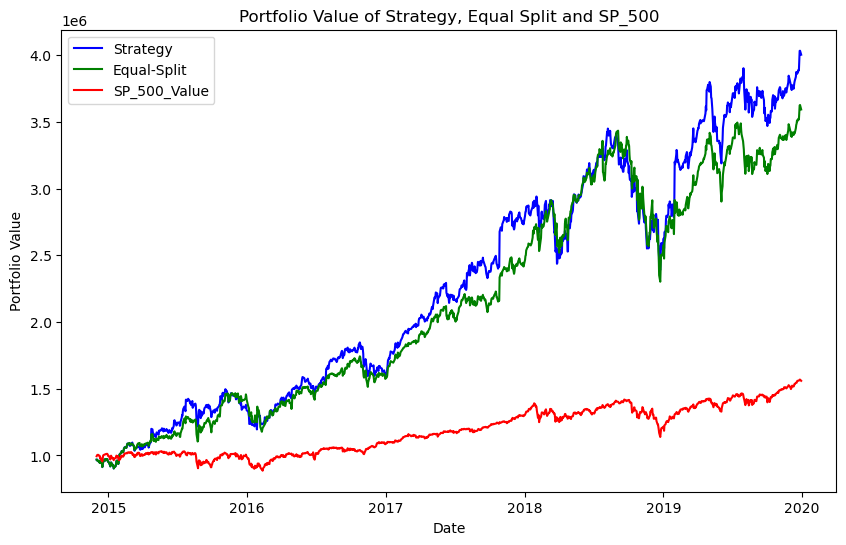

<Figure size 1000x500 with 0 Axes>

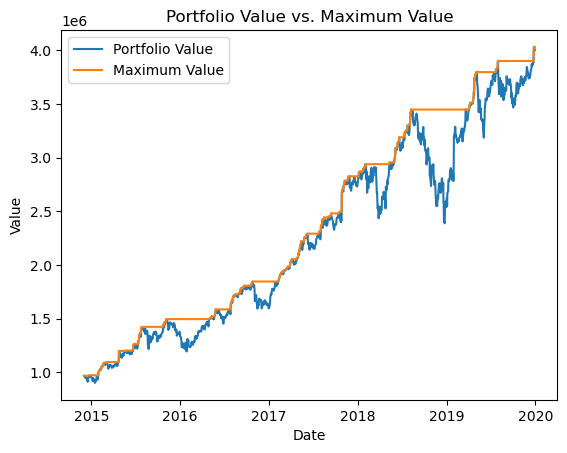

<Figure size 1000x500 with 0 Axes>

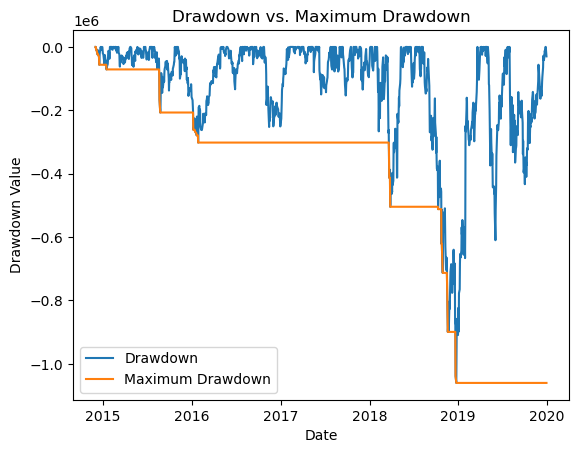

In [11]:
import pandas as pd
import yfinance as yf  # Yahoo Finance API for fetching stock data
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import io
import sys
import dash_table
import plotly.graph_objs as go

In [12]:
class BackTester:
    
    def __init__(self, ticker_options, start_date, end_date, initial_capital, STMA, LTMA):
        self.tickers = ticker_options
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.STMA = STMA
        self.LTMA = LTMA
        self.MACD_line = 9
        
        self.columns_to_drop = ['High', 'Low', 'Dividends', 'Stock Splits']
        self.result_df = pd.DataFrame()
        self.window_size_K = 21
        self.window_size_D = 5
        
        for each_stock in self.tickers:
            stock_data = yf.Ticker(each_stock)
            hist_stock_data = stock_data.history(start = self.start_date, end = self.end_date)
            hist_stock_data_copy = hist_stock_data.copy()
            hist_stock_data_copy = hist_stock_data_copy.drop(self.columns_to_drop, axis=1)
            hist_stock_data_copy.columns = [each_stock + '_' + col for col in hist_stock_data_copy.columns]
            self.result_df = pd.concat([self.result_df, hist_stock_data_copy], axis=1)
            
    #calculate stochastic oscillator
    def calculate_SO(self):
        for each_stock in self.tickers:
            stock_close_column = each_stock + '_Close'
            stock_SO_K = each_stock + '_SO_K'
            stock_SO_D = each_stock + '_SO_D'
            stock_Highest_L14 = each_stock + '_Highest_in_L14'
            stock_Lowest_L14 = each_stock + '_Lowest_in_L14'
            stock_recent_price = each_stock + '_recent_price'
            stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
            self.result_df[stock_Highest_L14] = self.result_df[stock_close_column].rolling(window=self.window_size_K).max()
            self.result_df[stock_Lowest_L14] = self.result_df[stock_close_column].rolling(window=self.window_size_K).min()
            self.result_df[stock_recent_price] = self.result_df[stock_close_column]
            self.result_df[stock_SO_K] = ((self.result_df[stock_recent_price] - self.result_df[stock_Lowest_L14])/(self.result_df[stock_Highest_L14] - self.result_df[stock_Lowest_L14])) * 100 
            self.result_df[stock_SO_D] = self.result_df[stock_SO_K].rolling(window=self.window_size_D).mean()
            conditions = [(self.result_df[stock_SO_D] < 25),(self.result_df[stock_SO_D] > 75)]
            choices = ['Buy','Sell']
            self.result_df[stock_SO_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
            temp_columns = [stock_Highest_L14, stock_Lowest_L14, stock_recent_price]
            self.result_df = self.result_df.drop(temp_columns, axis=1)
        return self.result_df
    
    #calculate MACD
    def calculate_MACD(self):
        for each_stock in self.tickers:
            stock_close_column = each_stock + '_Close'
            stock_MACD = each_stock + '_MACD'
            stock_signal_MACD = each_stock + '_signal_MACD'
            stock_signal_MACD_diff = each_stock + '_signal_MACD_diff'
            stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
            Short_EMA = self.result_df[stock_close_column].ewm(span=self.STMA, adjust=False).mean()
            Long_EMA = self.result_df[stock_close_column].ewm(span=self.LTMA, adjust=False).mean()
            MACD = Short_EMA - Long_EMA
            signal = MACD.ewm(span=self.MACD_line, adjust=False).mean()
            self.result_df[stock_MACD] = MACD
            self.result_df[stock_signal_MACD] = signal
            self.result_df[stock_signal_MACD_diff] = self.result_df[stock_MACD] - self.result_df[stock_signal_MACD]
            conditions = [
                (self.result_df[stock_signal_MACD_diff] > 0) & (self.result_df[stock_signal_MACD_diff].shift(1) < 0), 
                (self.result_df[stock_signal_MACD_diff] < 0) & (self.result_df[stock_signal_MACD_diff].shift(1) > 0) 
            ]
            choices = ['Buy','Sell']
            self.result_df[stock_MACD_Buy_Sell_decision] = np.select(conditions, choices, default='NA')   
        return self.result_df
    
    #finalise Buy/Sell
    def final_buy_sell(self):
        for each_stock in self.tickers:
            stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
            stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
            stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
            conditions = [
                (self.result_df[stock_SO_Buy_Sell_decision] == "Buy") & (self.result_df[stock_MACD_Buy_Sell_decision] == "Buy"), 
                (self.result_df[stock_SO_Buy_Sell_decision] == "Sell") & (self.result_df[stock_MACD_Buy_Sell_decision] == "Sell")
            ]
            choices = ['Buy','Sell']
            self.result_df[stock_Final_BorS_Decision] = np.select(conditions, choices, default='NA')
        return self.result_df
    
    #print buy/sell decision count
    def print_buy_sell_count(self):
        for each_stock in self.tickers:
            stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
            #print(each_stock)
            #print(self.result_df[stock_Final_BorS_Decision].value_counts())
            
    #Buy and selling of shares following the strategy based on the B/S signals from SO and MACD
    def execute_buy_sell(self):
        self.result_df.index = pd.to_datetime(self.result_df.index)
        self.result_df['Cash Balance'] = 0
        initial_date = self.result_df.index[0]
        initial_date = initial_date.tz_localize(None)
        #df.loc['2015-01-02', 'Cash balance'] = 1000000
    
        #Add columns for shares owned & initial allocation
        for stock in self.tickers:
            self.result_df[stock + '_owned_shares'] = 0 
            if stock + '_Open' in self.result_df.columns:  
                initial_price = self.result_df.loc[initial_date, stock + '_Open']
                no_of_stocks = len(self.tickers)
                each_stock_cash = self.initial_capital/no_of_stocks
                self.result_df.loc[initial_date, stock + '_owned_shares'] = round(each_stock_cash / initial_price)   

        #print("Initial Capital: ",self.initial_capital)
        start_index = self.result_df.index.get_loc(initial_date) + 1
    
        # Iterate over the DataFrame for next day execution based on the previous day's decisions
        for i in range(start_index, len(self.result_df.index)):
            current_date = self.result_df.index[i]
            previous_date = self.result_df.index[i - 1]

            # Initialize daily cash balance based on the previous day's ending balance
            daily_cash_balance = self.result_df.at[previous_date, 'Cash Balance']

            buy_stocks = []
            sell_stocks = []

            for stock in self.tickers:
                decision_column = stock + '_Final_BorS_Decision'  # Adjust based on actual column names
                if self.result_df.at[previous_date, decision_column] == 'Buy':
                    #print(current_date, " - Buy - " ,stock)
                    buy_stocks.append(stock)
                elif self.result_df.at[previous_date, decision_column] == 'Sell':
                    #print(current_date, " - Sell - " , stock)
                    sell_stocks.append(stock)
        
            # Execute sells first to update the cash balance
            if sell_stocks:
                for stock in sell_stocks:
                    #print(current_date, " - Sell - " ,stock)
                    sell_price = self.result_df.at[current_date, stock + '_Open']
                    #print("Selling price ", sell_price)
                    shares_to_sell = self.result_df.at[previous_date, stock + '_owned_shares']
                    #print("Previous date ", previous_date)
                    #print("Stocks owned on previous date (shares to sell): ", shares_to_sell)
                    daily_cash_balance = daily_cash_balance + (sell_price * shares_to_sell) # Increase cash balance
                    #print("Cash Balance after selling shares: ", daily_cash_balance)
                    #self.result_df.at[current_date, stock + '_owned_shares'] = 0  # Reset shares to 0 after selling
                    #print("Shares owned on current date after selling: ", self.result_df.at[current_date, stock + '_owned_shares'])   
                if not buy_stocks:
                    all_stocks = set(self.tickers)
                    sell_set = set(sell_stocks)
                    not_sell = all_stocks - sell_set
                    buy_stocks = list(not_sell)
                    #print("Not sell stocks: ",not_sell)
                    #print("buy_stocks list after selling shares: ",buy_stocks)
                    
            # Execute buys with the updated cash balance
            if buy_stocks:
                cash_per_stock = daily_cash_balance / len(buy_stocks) if daily_cash_balance > 0 else 0
                for stock in buy_stocks:
                    if cash_per_stock > 0:
                        #print(current_date, " - Buy - " ,stock)
                        buy_price = self.result_df.at[current_date, stock + '_Open']
                        #print("Buying price ", buy_price)
                        shares_to_buy = round(cash_per_stock / buy_price)
                        #print("Previous date ", previous_date)
                        #print("Stocks owned on previous date: ", self.result_df.at[previous_date, stock + '_owned_shares'])
                        #print("Shares to buy: ", shares_to_buy)
                        self.result_df.at[current_date, stock + '_owned_shares'] = self.result_df.at[previous_date, stock + '_owned_shares'] + shares_to_buy  # Add bought shares
                        #print("Shares owned after buying: ", self.result_df.at[current_date, stock + '_owned_shares'])
                        daily_cash_balance = daily_cash_balance - (shares_to_buy * buy_price)  # Deduct spent cash
                    else:
                        self.result_df.at[current_date, stock + '_owned_shares'] = self.result_df.at[previous_date, stock + '_owned_shares']
                    
            all_stocks = set(self.tickers)
            buy_set = set(buy_stocks)
            sell_set = set(sell_stocks)
        
            no_transaction_stocks = all_stocks - (buy_set.union(sell_set))
            #print(current_date, 'No transaction stocks : ' , no_transaction_stocks)
            for stock in no_transaction_stocks:
                self.result_df.at[current_date, stock + '_owned_shares'] = self.result_df.at[previous_date, stock + '_owned_shares']

            # Update the cash balance at the end of the day
            self.result_df.at[current_date, 'Cash Balance'] = daily_cash_balance
        return self.result_df
    
    #Calculation of the Portfolio value if 1M is invested through the Strategy 2: Defensive Entry Points
    def calculate_portfolio_value(self):
        self.result_df.index = pd.to_datetime(self.result_df.index)
        self.result_df['Portfolio Value'] = 0
        initial_date = self.result_df.index[0]
        initial_date = initial_date.tz_localize(None)
        start_index = self.result_df.index.get_loc(initial_date)
    
        portfolio_value = 0
        current_date = self.result_df.index[start_index]
        #calculating the portfolio value on day 1 - 2015/01/02
        for stock in self.tickers:
            stock_value = self.result_df.at[current_date, stock + '_owned_shares'] * self.result_df.at[current_date, stock +'_Close']
            portfolio_value = portfolio_value + stock_value
        self.result_df.at[current_date, 'Portfolio Value'] = portfolio_value
    
        start_index = self.result_df.index.get_loc(initial_date) + 1
    
        # len(df.index)
        for i in range(start_index, len(self.result_df.index)): 
            portfolio_value = 0
            current_date = self.result_df.index[i]
            #print(current_date)
            for stock in self.tickers:
                stock_value = self.result_df.at[current_date, stock + '_owned_shares'] * self.result_df.at[current_date, stock +'_Close']
                portfolio_value = portfolio_value + stock_value
                #print(current_date, ' ', portfolio_value)
                #print(portfolio_value)
            self.result_df.at[current_date, 'Portfolio Value'] = portfolio_value
    
        return self.result_df
    
    #Calculation of the portfolio value if 1M had been invested equally in the start of the specified period    
    def calculate_no_strategy_portfolio_value(self):
        for stock in self.tickers:
            stock_initial_owned = stock + 'initial_owned'
            stock_initial_owned = self.result_df.at[self.result_df.index[0], stock + '_owned_shares']
            #print("Initial stocks owned: ", stock_initial_owned) 
    
            self.result_df.index = pd.to_datetime(self.result_df.index)
            self.result_df['NS Portfolio Value'] = 0
            initial_date = self.result_df.index[0]
            initial_date = initial_date.tz_localize(None)
            start_index = self.result_df.index.get_loc(initial_date)
    
            for i in range(start_index, len(self.result_df.index)): 
                ns_portfolio_value = 0
                current_date = self.result_df.index[i]
                #print(current_date)
                for stock in self.tickers:
                    stock_initial_owned = stock + 'initial_owned'
                    stock_initial_owned = self.result_df.at[self.result_df.index[0], stock + '_owned_shares']
                    #print("Initial stocks owned: ", stock_initial_owned)
                    stock_value = stock_initial_owned * self.result_df.at[current_date, stock +'_Close']
                    ns_portfolio_value = ns_portfolio_value + stock_value
                    #print(current_date, ' ', portfolio_value)
                    #print(portfolio_value)
                #print("NS Portfolio Value: ", ns_portfolio_value)
                self.result_df.at[current_date, 'NS Portfolio Value'] = ns_portfolio_value
            return self.result_df
        
    #calculation of portfolio value if 1M was invested in the S&P index at the start of the specified period
    def calculate_SP_500_value(self):
        ticker_symbol = "^GSPC"
        sp500_data = yf.download(ticker_symbol, start=self.start_date, end=self.end_date)
        sp500_data.index = pd.to_datetime(sp500_data.index)
        initial_date = self.result_df.index[0]
        initial_date = initial_date.tz_localize(None)
    
        sp500_units_for_1M = round(self.initial_capital/sp500_data.at[initial_date, 'Open'])
        self.result_df.index = self.result_df.index.date
        self.result_df['SP_500_Value_per_unit'] = sp500_data['Close']
        self.result_df['SP_500_Total_Value'] = sp500_units_for_1M * self.result_df['SP_500_Value_per_unit']
    
        return self.result_df
    
    #calculation of metrics
    def calculate_metrics(self):
        #Calculation of returns
        #initial_portfolio_value = 1000000 #1M was split and invested equally initially
        print("Initial Investment: ", self.initial_capital)
        print("------------------------------------------------")
        #strategy
        final_portfolio_value = self.result_df.at[self.result_df.index[-1], 'Portfolio Value']
        strategy_returns = ((final_portfolio_value-self.initial_capital)/(self.initial_capital)) * 100
        print("Final strategy portfolio value: ", final_portfolio_value)
        print("Strategy Returns: ", round(strategy_returns, 2), "%")
        print("------------------------------------------------")
        #no_strategy
        final_ns_portfolio_value = self.result_df.at[self.result_df.index[-1], 'NS Portfolio Value']
        ns_strategy_returns = ((final_ns_portfolio_value-self.initial_capital)/(self.initial_capital)) * 100
        print("Final equal split portfolio value: ", final_ns_portfolio_value)
        print("No Strategy Returns (Equal Split): ", round(ns_strategy_returns, 2), "%")
        print("\n\n\n------------------------------------------------\n\n\n")
        #S&P500
        final_sp500_value = self.result_df.at[self.result_df.index[-1], 'SP_500_Total_Value']
        sp500_returns = ((final_sp500_value-self.initial_capital)/(self.initial_capital)) * 100
        print("Final SP_500 value: ", final_sp500_value)
        print("SP 500 Returns: ", round(sp500_returns, 2), "%")
        print("------------------------------------------------")
        #Annualized returns CAGR
        start_date_str = datetime.strptime(self.start_date, '%Y-%m-%d')
        end_date_str = datetime.strptime(self.end_date, '%Y-%m-%d')
        difference_in_years = (end_date_str - start_date_str).days / 365.25
        annualised_strategy_returns = ((1 + (strategy_returns/100)) ** (1/difference_in_years)) - 1
        annualised_ns_returns = ((1 + (ns_strategy_returns/100)) ** (1/difference_in_years)) - 1
        annualised_sp_returns = ((1 + (sp500_returns/100)) ** (1/difference_in_years)) - 1
    
        print(f"Strategy returns (Annualised): {annualised_strategy_returns * 100:.2f}%")
        print(f"No Strategy returns (Annualised): {annualised_ns_returns * 100:.2f}%")
        print(f"SP returns (Annualised): {annualised_sp_returns * 100:.2f}%")
    
        self.result_df['Strategy_Portfolio_DReturns'] = self.result_df['Portfolio Value'].pct_change()
        self.result_df['NS_Portfolio_DReturns'] = self.result_df['NS Portfolio Value'].pct_change()
        self.result_df['SP_500_DReturns'] = self.result_df['SP_500_Total_Value'].pct_change()
    
        #Calculation of risk
        strategy_risk = self.result_df['Strategy_Portfolio_DReturns'].std()
        ns_risk = self.result_df['NS_Portfolio_DReturns'].std()
        sp_500_risk = self.result_df['SP_500_DReturns'].std()
        print("------------------------------------------------")
        print(f"Strategy risk (Daily): {strategy_risk * 100:.2f}%")
        print(f"No Strategy risk (Daily): {ns_risk * 100:.2f}%")
        print(f"SP 500 (Daily): {sp_500_risk * 100:.2f}%")
        print("------------------------------------------------")
        print(f"Strategy risk (Monthly): {strategy_risk * np.sqrt(21) * 100:.2f}%")
        print(f"No Strategy risk (Monthly): {ns_risk * np.sqrt(21) * 100:.2f}%")
        print(f"SP 500 risk (Monthly): {sp_500_risk * np.sqrt(21) * 100:.2f}%")
        print("------------------------------------------------")
        print(f"Strategy risk (Annualised): {strategy_risk * np.sqrt(252) * 100:.2f}%")
        print(f"No Strategy risk (Annualised): {ns_risk * np.sqrt(252) * 100:.2f}%")
        print(f"SP 500 risk (Annualised): {sp_500_risk * np.sqrt(252) * 100:.2f}%")
        print("------------------------------------------------")
    
        print("Performance metrics of the Strategy")
        #Calculating Sharpe ratio of strategy
        annualised_strategy_risk = strategy_risk * np.sqrt(252)
        risk_free_rate = 0.0227 #calculated as the average yield of the 10-year t-bill rate over the given 5 year period
        sharpe_ratio = (annualised_strategy_returns - risk_free_rate)/annualised_strategy_risk
        print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
        #Calculating Sortino ratio of strategy
        negative_daily_returns = self.result_df['Strategy_Portfolio_DReturns'][self.result_df['Strategy_Portfolio_DReturns'] < 0]
        downside_deviation = np.std(negative_daily_returns) * np.sqrt(252)
        sortino_ratio = (annualised_strategy_returns - risk_free_rate) / downside_deviation
        print(f"Sortino Ratio: {sortino_ratio:.2f}")
        #Calculating beta of the strategy
        covariance = self.result_df['Strategy_Portfolio_DReturns'].cov(self.result_df['SP_500_DReturns'])
        market_variance = self.result_df['SP_500_DReturns'].var()
        beta = covariance / market_variance
        print(f"Beta of the Strategy: {beta:.2f}")
        #Calculating alpha of the strategy
        alpha = annualised_strategy_returns - (risk_free_rate + beta * (annualised_sp_returns - risk_free_rate))
        print(f"Alpha of the Strategy: {alpha:.4f}")
        print("------------------------------------------------")
        
        metrics = {
            'Initial_Investment': self.initial_capital,
            'Final_Strategy_Portfolio_Value':final_portfolio_value,
            'Strategy_Returns':strategy_returns,
            'Final_Equal_Split_Portfolio_Value':final_ns_portfolio_value,
            'No_Strategy_Returns':ns_strategy_returns,
            'Final_SP_500_Value':final_sp500_value,
            'SP_500_Returns':sp500_returns,
            '''
            'Strategy_Returns_Annualised'
            'No_Strategy_Returns_Annualised'
            'SP_Returns_Annualised'
            'Strategy_Risk_Daily'
            'No_Strategy_Risk_Daily'
            'SP_500_Daily'
            'Strategy_Risk_Annualised'
            'No_Strategy_Risk_Annualised'
            'SP_500_Annualised'
            '''
            'Sharpe_Ratio':sharpe_ratio,
            'Sortino_Ratio':sortino_ratio,
            'Beta':beta,
            'Alpha':alpha
        }
        
        
        return metrics
    
    #plot graph
    def plot_portfolio_value_graph(self):
        plt.figure(figsize=(10, 6))  # Set the figure size (optional)
        plt.plot(self.result_df.index, self.result_df['Portfolio Value'], label='Strategy', color='blue')  # Line for Column1
        plt.plot(self.result_df.index, self.result_df['NS Portfolio Value'], label='Equal-Split', color='green')  # Line for Column2
        plt.plot(self.result_df.index, self.result_df['SP_500_Total_Value'], label='SP_500_Value', color='red')  # Line for Column3
        # Adding title and labels
        plt.title('Portfolio Value of Strategy, Equal Split and SP_500')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        # Show legend
        plt.legend()
        # Display the plot
        return plt
        
    def plot_PortfolioValue_MaxValue(self):
        self.result_df['Maximum Value'] = self.result_df['Portfolio Value'].cummax()
        plt.figure(figsize=(10, 5))
        self.result_df[['Portfolio Value', 'Maximum Value']].dropna().plot()
        plt.xlabel('Date')  # X-axis label
        plt.ylabel('Value')  # Y-axis label
        plt.title('Portfolio Value vs. Maximum Value')  # Adding a title for clarity
        plt.legend()
        return plt
        
    def plot_drawdown_vs_max_drawdown(self):
        self.result_df['Drawdown'] = self.result_df['Portfolio Value'] - self.result_df['Maximum Value']
        self.result_df['Drawdown (%)'] = self.result_df['Drawdown']/self.result_df['Maximum Value']
        self.result_df['Maximum Drawdown'] = self.result_df['Drawdown'].cummin()
        plt.figure(figsize=(10, 5))
        self.result_df[['Drawdown', 'Maximum Drawdown']].dropna().plot()
        plt.xlabel('Date')  # X-axis label
        plt.ylabel('Drawdown Value')  # Y-axis label
        plt.title('Drawdown vs. Maximum Drawdown')  # Adding a title for clarity
        plt.legend()
        #plt.show()
        return plt
    
    #write the result-df in a csv file
    def write_df_CSV(self):
        self.result_df.to_csv("group_hw.csv")

In [13]:
'''
tickers = ['AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2014-12-01'
end_date = '2019-12-31'
initial_capital = 1000000
SMTA = 12
LMTA = 26

backtest = BackTester(tickers, start_date, end_date, initial_capital, SMTA, LMTA)
backtest.calculate_SO()
backtest.calculate_MACD()
backtest.final_buy_sell()
backtest.print_buy_sell_count()
backtest.execute_buy_sell()
backtest.calculate_portfolio_value()
backtest.calculate_no_strategy_portfolio_value()
backtest.calculate_SP_500_value()
backtest.calculate_metrics()
backtest.plot_portfolio_value_graph()

backtest.write_df_CSV()
'''

"\ntickers = ['AAPL', 'AMZN', 'NFLX', 'GOOGL']\nstart_date = '2014-12-01'\nend_date = '2019-12-31'\ninitial_capital = 1000000\nSMTA = 12\nLMTA = 26\n\nbacktest = BackTester(tickers, start_date, end_date, initial_capital, SMTA, LMTA)\nbacktest.calculate_SO()\nbacktest.calculate_MACD()\nbacktest.final_buy_sell()\nbacktest.print_buy_sell_count()\nbacktest.execute_buy_sell()\nbacktest.calculate_portfolio_value()\nbacktest.calculate_no_strategy_portfolio_value()\nbacktest.calculate_SP_500_value()\nbacktest.calculate_metrics()\nbacktest.plot_portfolio_value_graph()\n\nbacktest.write_df_CSV()\n"

In [14]:
tickers = [
    "MSFT", "AAPL", "NVDA", "GOOGL", "AMZN", "META", "BRK-A", "TSM", "LLY", "AVGO",
    "JPM", "V", "TSLA", "WMT", "XOM", "MA", "NVO", "UNH", "ASML", "JNJ",
    "PG", "HD", "ORCL", "MRK", "TM", "ABBV", "COST", "CVX", "CRM", "BAC",
    "AMD", "NFLX", "KO", "SAP", "PEP", "DIS", "ACN", "ADBE", "LIN", "TMO",
    "AZN", "WFC", "MCD", "CSCO", "ABT", "NVS", "TMUS", "QCOM", "INTC", "BABA"
]
options = [{'label': ticker, 'value': ticker} for ticker in tickers]

In [15]:
# Create a Dash application
app = dash.Dash(__name__)

# Dropdown component with multi-select enabled
dropdown = dcc.Dropdown(
    id='selected_tickers',
    options=options,
    value=[tickers[0]],  # Default value, you can select multiple here
    multi=True  # Enables multi-selection
)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Algorithmic Trading Strategy Parameters"),
    html.Div([
        html.Label("Tickers (select multiple):"),
        dropdown
    ]),
    html.Div([
        html.Label("Start Date:"),
        dcc.Input(id='start_date', type='text', value='2015-01-01'),
    ]),
    html.Div([
        html.Label("End Date:"),
        dcc.Input(id='end_date', type='text', value='2019-12-31'),
    ]),
    html.Div([
        html.Label("Initial Capital:"),
        dcc.Input(id='initial_capital', type='number', value=1000000),
    ]),
    html.Div([
        html.Label("STMA:"),
        dcc.Input(id='STMA', type='number', value=12),
    ]),
    html.Div([
        html.Label("LTMA:"),
        dcc.Input(id='LTMA', type='number', value=26),
    ]),
    html.Button(id='submit_button', n_clicks=0, children='Submit'),
    html.Div(id='output_div'),
    dcc.Graph(id='portfolio_value_graph'),
    dcc.Graph(id='portfolio_value_max_graph'),
    dcc.Graph(id='drawdown_vs_max_drawdown_graph'),
    
])

# Define the callback to update the output based on inputs
@app.callback(
    [
        Output('output_div', 'children'),
        Output('portfolio_value_graph', 'figure'),
        Output('portfolio_value_max_graph', 'figure'),
        Output('drawdown_vs_max_drawdown_graph', 'figure'),
    ],
    [Input('submit_button', 'n_clicks')],
    [State('selected_tickers', 'value'),
     State('start_date', 'value'),
     State('end_date', 'value'),
     State('initial_capital', 'value'),
     State('STMA', 'value'),
     State('LTMA', 'value')]
)
def update_output(n_clicks, selected_tickers, start_date, end_date, initial_capital, STMA, LTMA):
    if n_clicks > 0:
        # Redirect stdout to capture prints
        old_stdout = sys.stdout
        redirected_output = sys.stdout = io.StringIO()
        
        print("selected tickers are: ",selected_tickers)
        # Assuming you want to execute something from a class that prints
        backtest = BackTester(selected_tickers, start_date, end_date, initial_capital, STMA, LTMA)
        backtest.calculate_SO()
        backtest.calculate_MACD()
        backtest.final_buy_sell()
        backtest.print_buy_sell_count()
        backtest.execute_buy_sell()
        backtest.calculate_portfolio_value()
        backtest.calculate_no_strategy_portfolio_value()
        backtest.calculate_SP_500_value()
        metrics = backtest.calculate_metrics()
        portfolio_value_fig = backtest.plot_portfolio_value_graph()
        portfolio_value_max_fig = backtest.plot_PortfolioValue_MaxValue()
        drawdown_vs_max_drawdown_fig = backtest.plot_drawdown_vs_max_drawdown()
        
        backtest.write_df_CSV()
        
        metrics_table = pd.DataFrame(metrics, index=[0])

        # Restore stdout
        sys.stdout = old_stdout
        
        dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} for i in metrics_table.columns],
        data=metrics_table.to_dict('records'),
        style_table={'height': '300px', 'overflowY': 'auto'}
        )

        # Get the captured output and return it for display
        output = redirected_output.getvalue()
        return output
    else:
        return "Enter tickers and click Submit to display output.", dash.no_update, dash.no_update, dash.no_update

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_79962/2459611369.py:103: FutureWarning:

Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_79962/2459611369.py:106: FutureWarning:

Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_79962/2459611369.py:103: FutureWarning:

Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_79962/2459611369.py:106: FutureWarning:

Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will ra

---------------------------------------------------------------------------
SchemaTypeValidationError                 Traceback (most recent call last)
SchemaTypeValidationError: Schema: [<Output `output_div.children`>, <Output `portfolio_value_graph.figure`>, <Output `portfolio_value_max_graph.figure`>, <Output `drawdown_vs_max_drawdown_graph.figure`>]
Path: ()
Expected type: (<class 'tuple'>, <class 'list'>)
Received value of type <class 'str'>:
    "selected tickers are:  ['MSFT', 'AAPL', 'GOOGL']\n"

Initial Investment:  1000000
------------------------------------------------
Final strategy portfolio value:  3189603.7204589844
Strategy Returns:  218.96 %
------------------------------------------------
Final equal split portfolio value:  3041908.3368377686
No Strategy Returns (Equal Split):  204.19 %



------------------------------------------------



Final SP_500 value:  1565546.958984375
SP 500 Returns:  56.55 %
------------------------------------------------
Strategy return